<a href="https://colab.research.google.com/github/RahafAlatiq0/CCTV_violence_detection/blob/main/Violence_Detection_YoloV8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Packages

In [1]:
!pip install onnx>=1.12.0 --quiet

In [2]:
!pip install ultralytics==8.0.134 --quiet
!pip install roboflow --quiet
!pip uninstall -y pycocotools --quiet
!pip install pycocotools --no-binary pycocotools --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.1/629.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 621.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from ultralytics import YOLO
from IPython.display import display, Image
from roboflow import Roboflow

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.134 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/107.7 GB disk)


In [4]:
HOME = os.getcwd()
print(HOME)

/content


## 2. Import dataset

In [5]:
!mkdir {HOME}/yolo_datasets
%cd {HOME}/yolo_datasets

/content/yolo_datasets


In [6]:
rf = Roboflow(api_key="qJLUbHOVjdzVuM0S1s0M")
project = rf.workspace('rahaf-5yhgj').project("violence-detection-rz92x")
dataset = project.version(3).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to violence-detection--3 in yolov8:: 100%|██████████| 4374/4374 [00:02<00:00, 2144.18it/s]


## 3. Exploratory Data Analysis

### A. Object Count Analysis

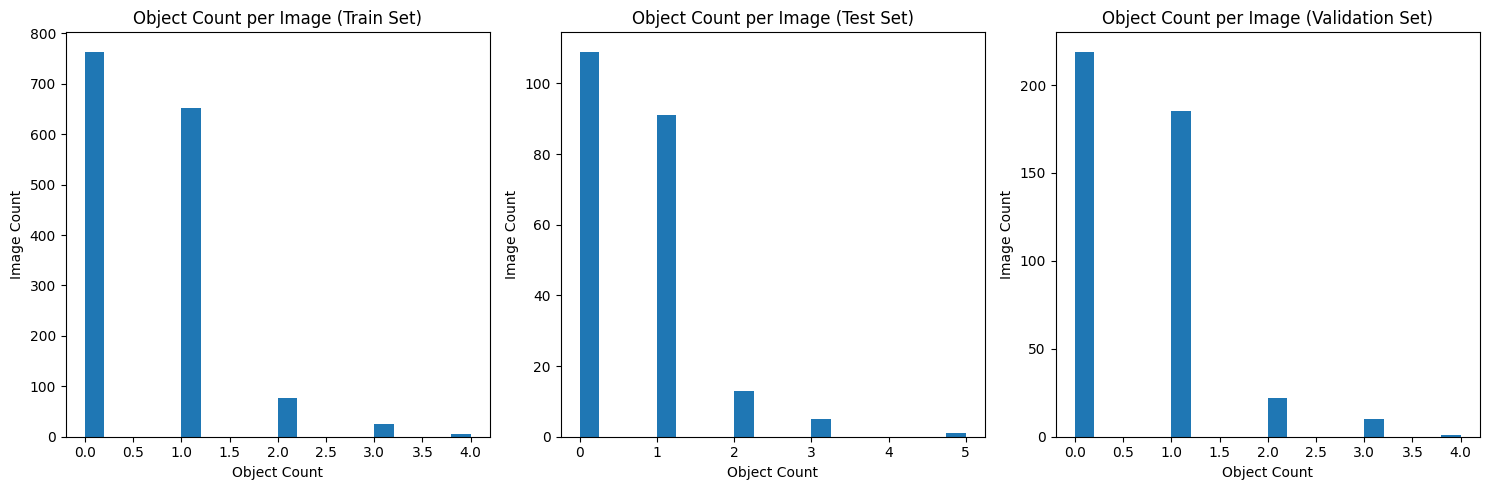

In [7]:
import matplotlib.pyplot as plt
import os

# Define the paths to the dataset folders
train_folder = '/content/yolo_datasets/violence-detection--3/train'
test_folder = '/content/yolo_datasets/violence-detection--3/test'
valid_folder = '/content/yolo_datasets/violence-detection--3/valid'

# Function to get the number of objects in each image
def get_object_counts(image_folder, label_folder):
    num_objects = []
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file.replace('.jpg', '.txt'))

        with open(label_path, 'r') as f:
            labels = f.read().splitlines()

        num_objects.append(len(labels))

    return num_objects

# Function to plot a histogram
def plot_histogram(data, title, xlabel, ylabel, ax):
    ax.hist(data, bins=20)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Get the number of objects per image in the train set
train_image_folder = os.path.join(train_folder, 'images')
train_label_folder = os.path.join(train_folder, 'labels')
train_object_counts = get_object_counts(train_image_folder, train_label_folder)

# Get the number of objects per image in the test set
test_image_folder = os.path.join(test_folder, 'images')
test_label_folder = os.path.join(test_folder, 'labels')
test_object_counts = get_object_counts(test_image_folder, test_label_folder)

# Get the number of objects per image in the validation set
valid_image_folder = os.path.join(valid_folder, 'images')
valid_label_folder = os.path.join(valid_folder, 'labels')
valid_object_counts = get_object_counts(valid_image_folder, valid_label_folder)

# Plot the histograms horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_histogram(train_object_counts, 'Object Count per Image (Train Set)', 'Object Count', 'Image Count', axs[0])
plot_histogram(test_object_counts, 'Object Count per Image (Test Set)', 'Object Count', 'Image Count', axs[1])
plot_histogram(valid_object_counts, 'Object Count per Image (Validation Set)', 'Object Count', 'Image Count', axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### B. Class Distribution Analysis

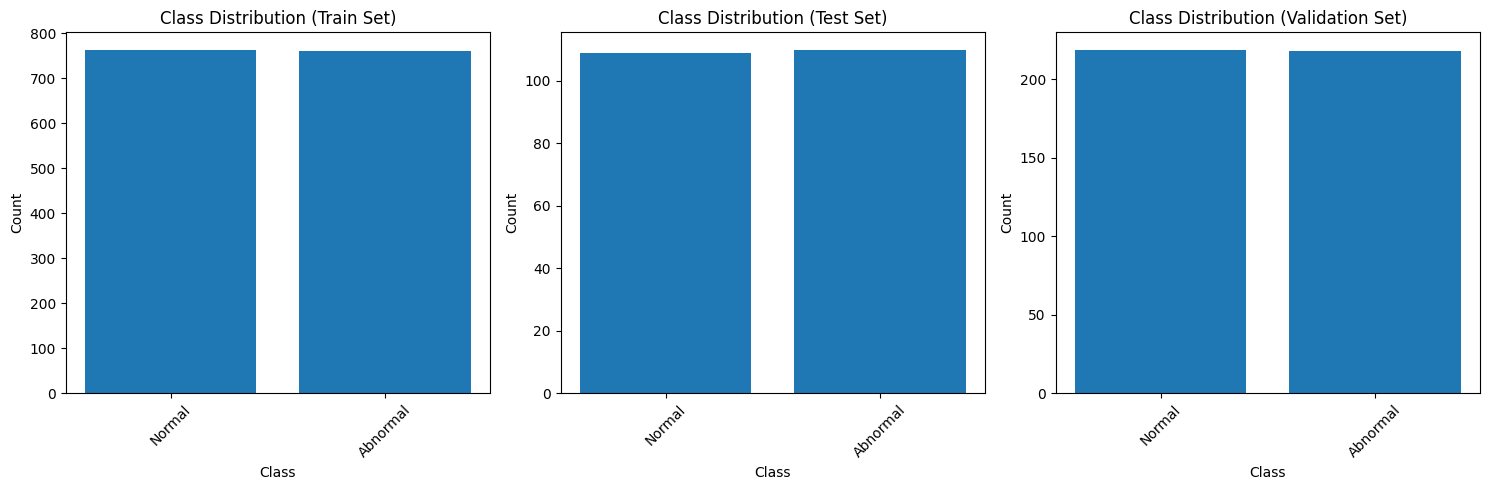

In [11]:
import os
import matplotlib.pyplot as plt

def get_class_distribution(image_folder):
    class_counts = {"Normal": 0, "Abnormal": 0}
    for image_file in os.listdir(image_folder):
        image_name = image_file.split('.')[0]

        if image_name.startswith("Normal"):
            class_counts["Normal"] += 1
        elif image_name.startswith("abnormal"):
            class_counts["Abnormal"] += 1

    return class_counts

# Define the paths to the dataset folders
train_folder = '/content/yolo_datasets/violence-detection--3/train/images'
test_folder = '/content/yolo_datasets/violence-detection--3/test/images'
valid_folder = '/content/yolo_datasets/violence-detection--3/valid/images'

# Get the class distribution in the train set
train_class_distribution = get_class_distribution(train_folder)

# Get the class distribution in the test set
test_class_distribution = get_class_distribution(test_folder)

# Get the class distribution in the validation set
valid_class_distribution = get_class_distribution(valid_folder)

# Plot the class distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

class_names_train = train_class_distribution.keys()
class_counts_train = train_class_distribution.values()
axs[0].bar(class_names_train, class_counts_train)
axs[0].set_title('Class Distribution (Train Set)')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)

class_names_test = test_class_distribution.keys()
class_counts_test = test_class_distribution.values()
axs[1].bar(class_names_test, class_counts_test)
axs[1].set_title('Class Distribution (Test Set)')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

class_names_valid = valid_class_distribution.keys()
class_counts_valid = valid_class_distribution.values()
axs[2].bar(class_names_valid, class_counts_valid)
axs[2].set_title('Class Distribution (Validation Set)')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Count')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### C. Object Size Distribution Analysis

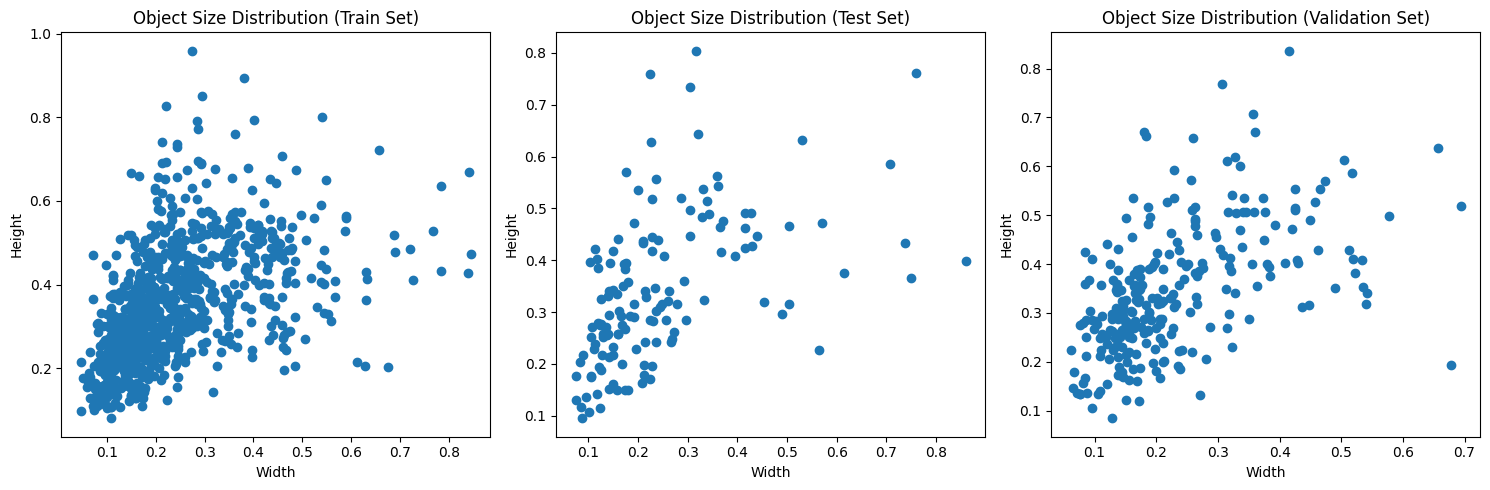

In [ ]:
# Function to get object sizes (width and height)
def get_object_sizes(image_folder, label_folder):
    object_sizes = []
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file.replace('.jpg', '.txt'))

        with open(label_path, 'r') as f:
            labels = f.read().splitlines()

        for label in labels:
            _, _, width, height = map(float, label.split()[1:])
            object_sizes.append((width, height))

    return object_sizes

# Get the object sizes in the train set
train_object_sizes = get_object_sizes(train_image_folder, train_label_folder)
train_widths, train_heights = zip(*train_object_sizes)

# Get the object sizes in the test set
test_object_sizes = get_object_sizes(test_image_folder, test_label_folder)
test_widths, test_heights = zip(*test_object_sizes)

# Get the object sizes in the validation set
valid_object_sizes = get_object_sizes(valid_image_folder, valid_label_folder)
valid_widths, valid_heights = zip(*valid_object_sizes)

# Plot the object size distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Train set
axs[0].scatter(train_widths, train_heights)
axs[0].set_title('Object Size Distribution (Train Set)')
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')

# Test set
axs[1].scatter(test_widths, test_heights)
axs[1].set_title('Object Size Distribution (Test Set)')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Height')

# Validation set
axs[2].scatter(valid_widths, valid_heights)
axs[2].set_title('Object Size Distribution (Validation Set)')
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Height')

plt.tight_layout()
plt.show()

## 4. Data Modeling

#### Model Training :

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data=/content/yolo_datasets/violence-detection-1/data.yaml epochs=35 imgsz=640 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 53.6MB/s]
New https://pypi.org/project/ultralytics/8.0.180 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.134 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/yolo_datasets/violence-detection-1/data.yaml, epochs=35, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, lin

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1200.jpg
confusion_matrix_normalized.png			    train_batch1201.jpg
confusion_matrix.png				    train_batch1202.jpg
events.out.tfevents.1694879090.3be54d681a84.1319.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


/content


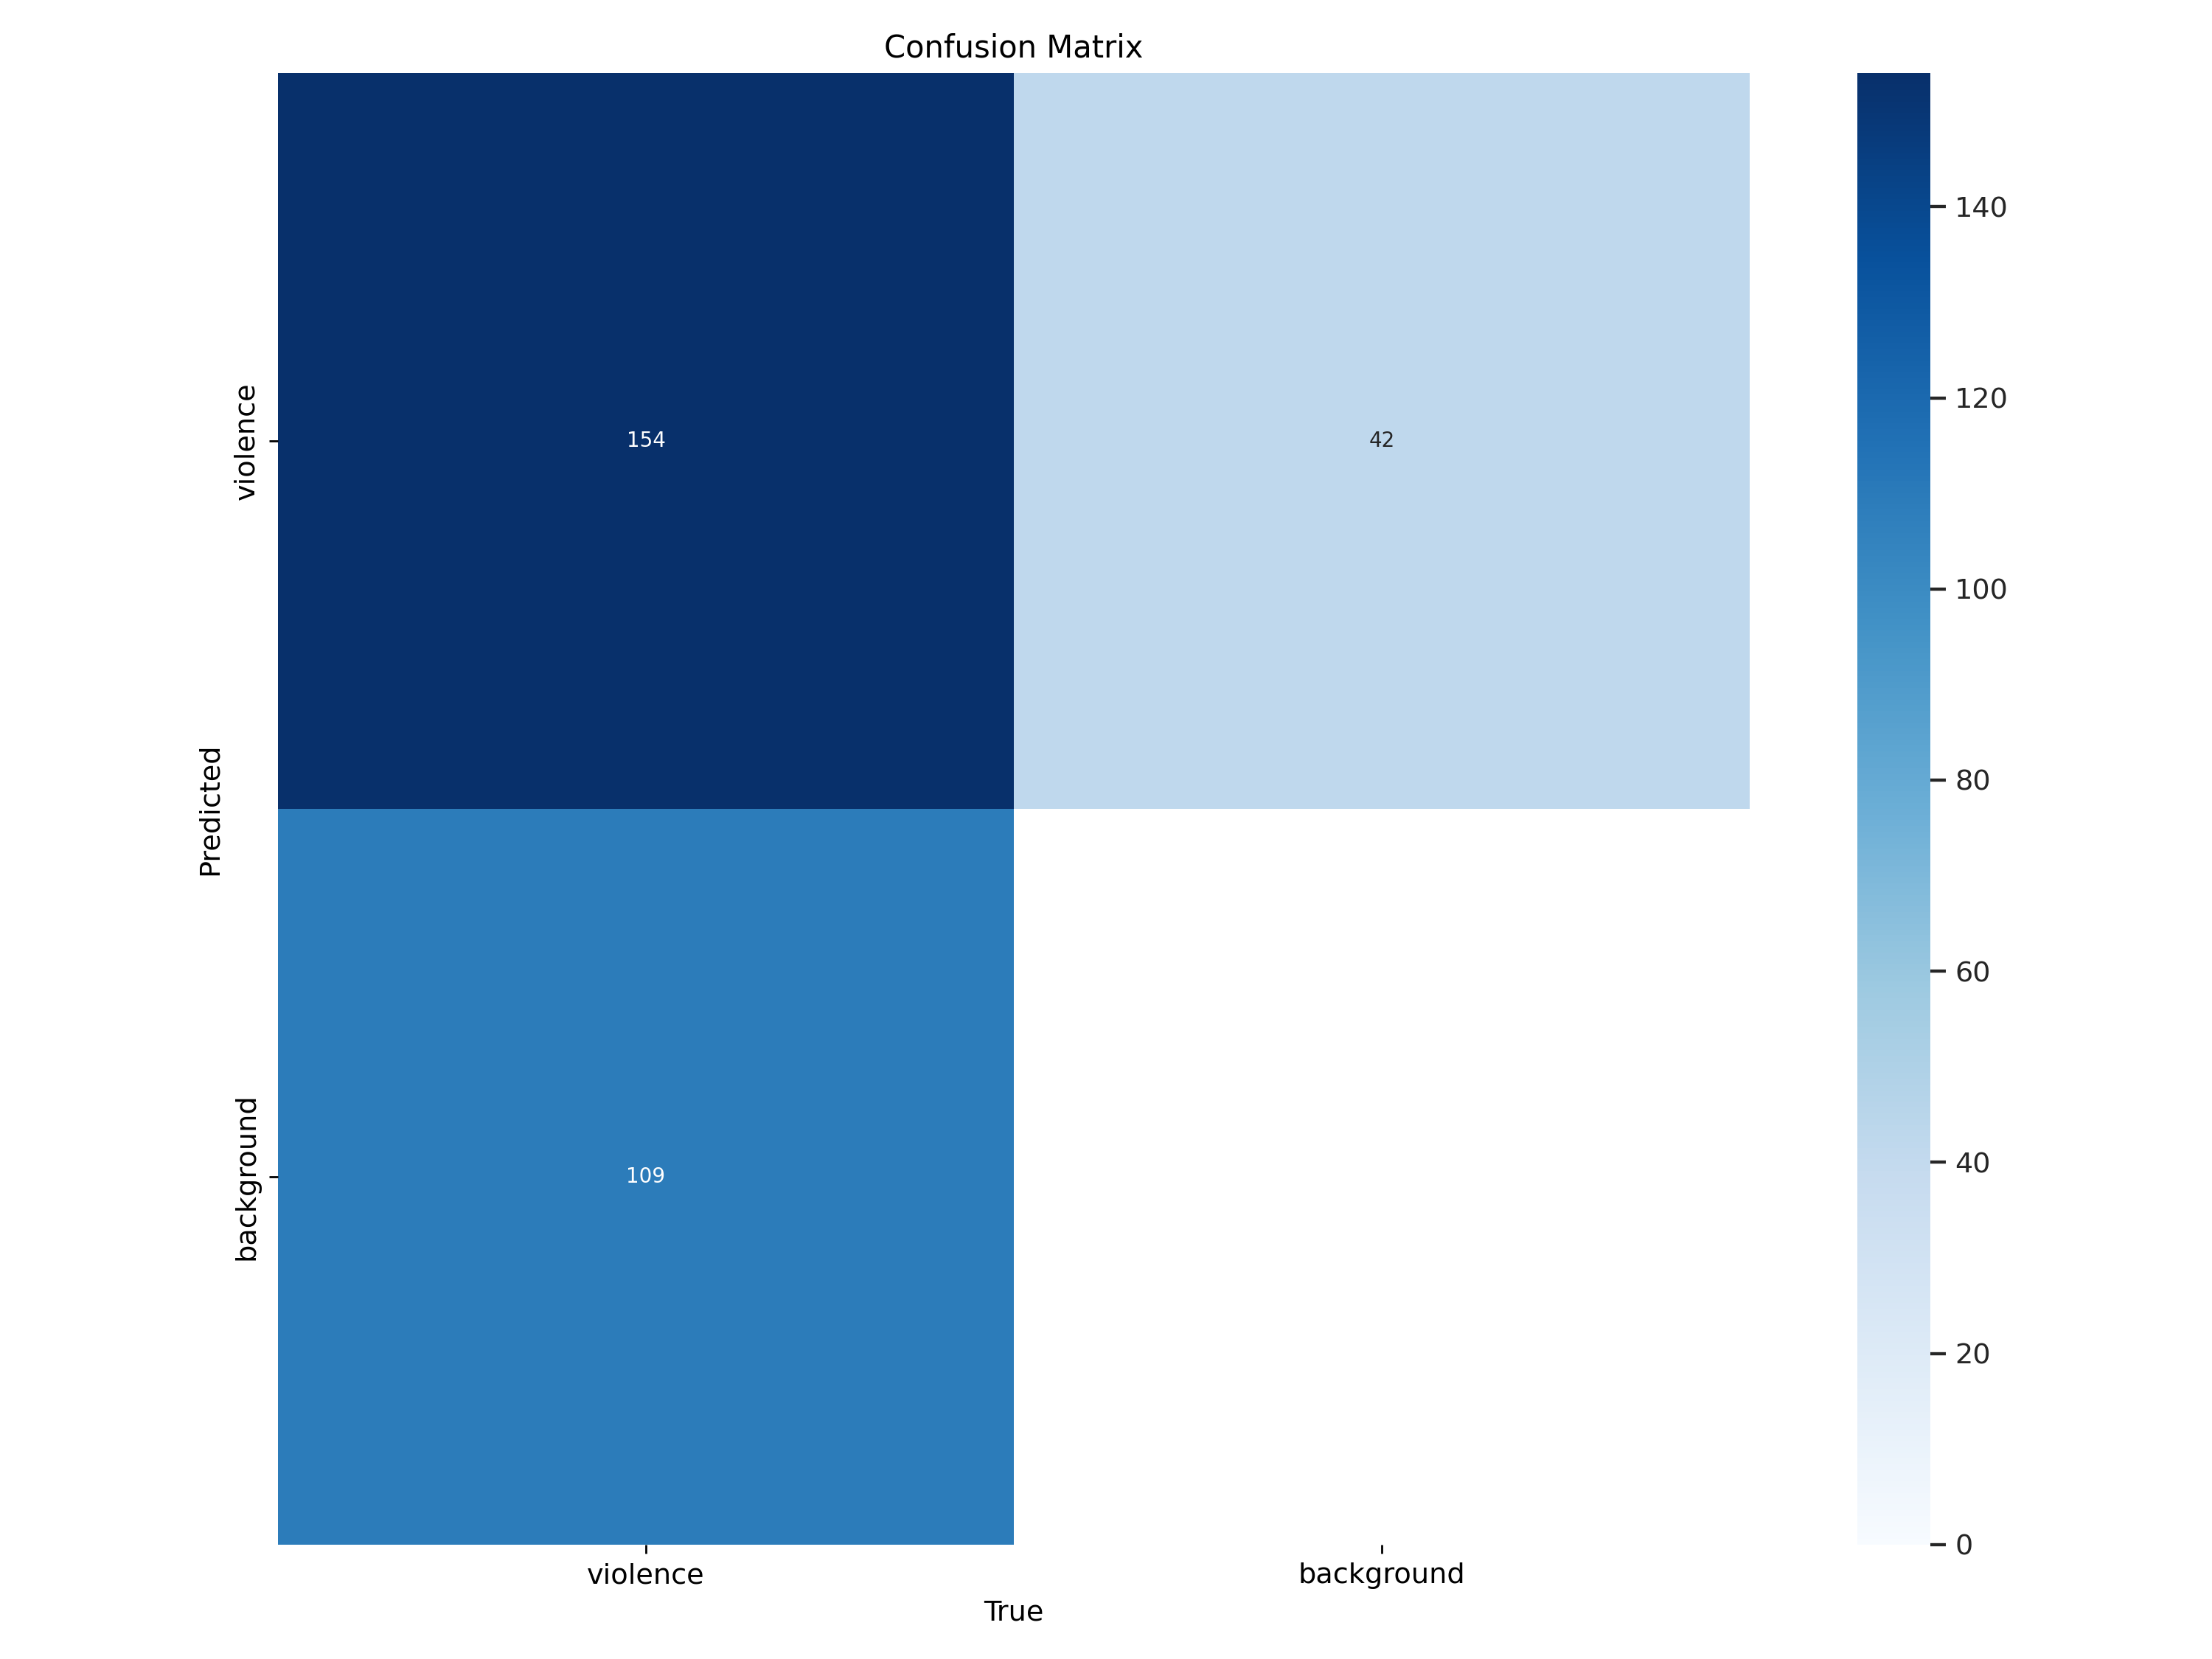

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


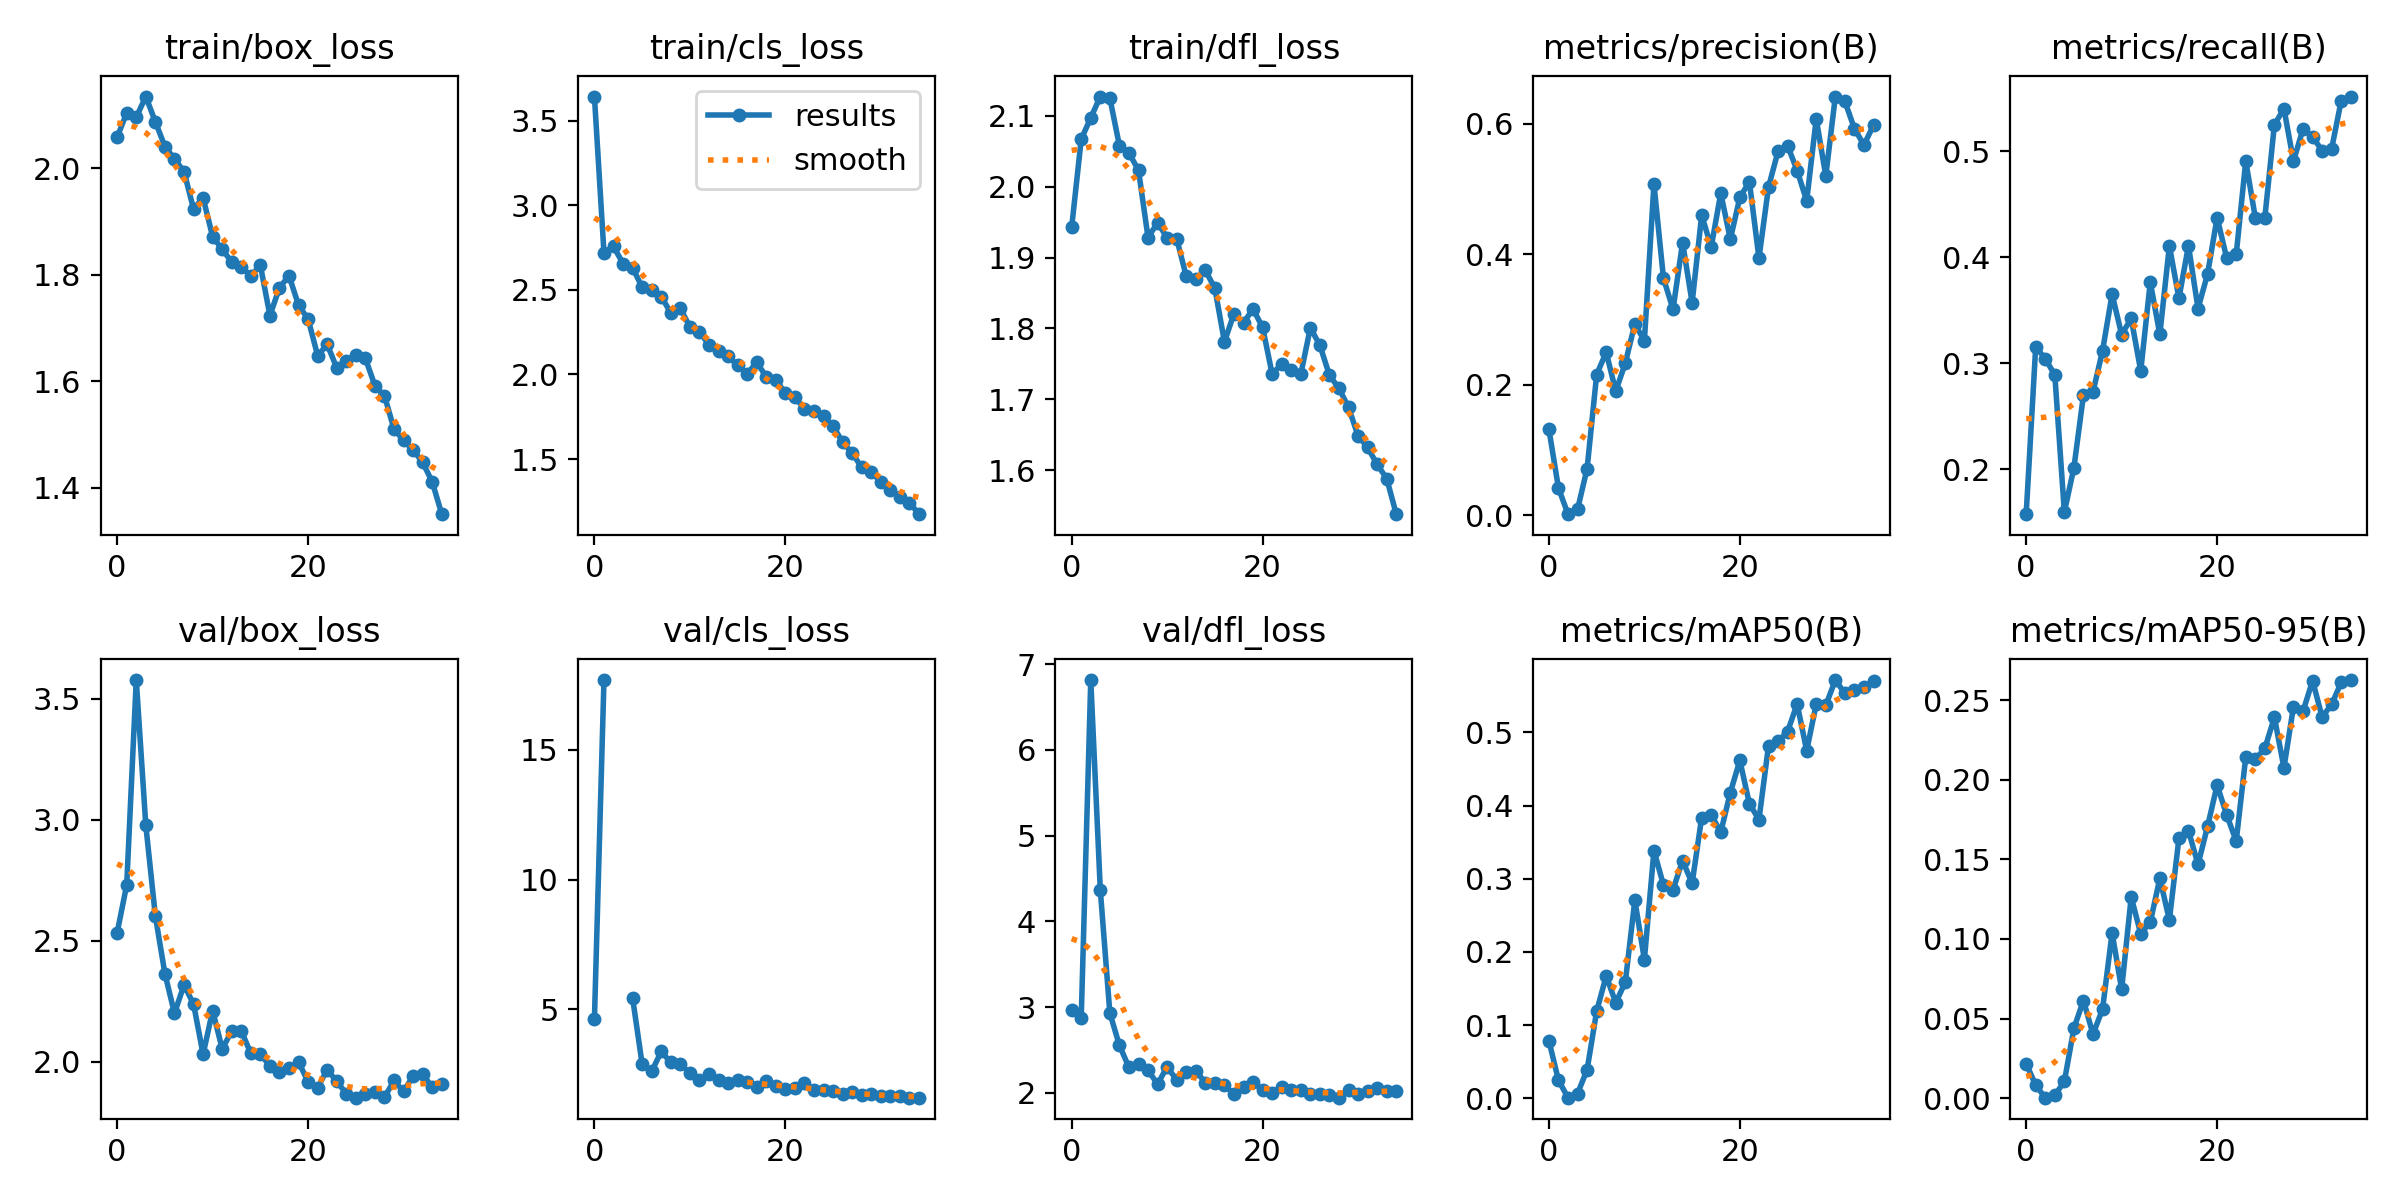

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=900)

/content


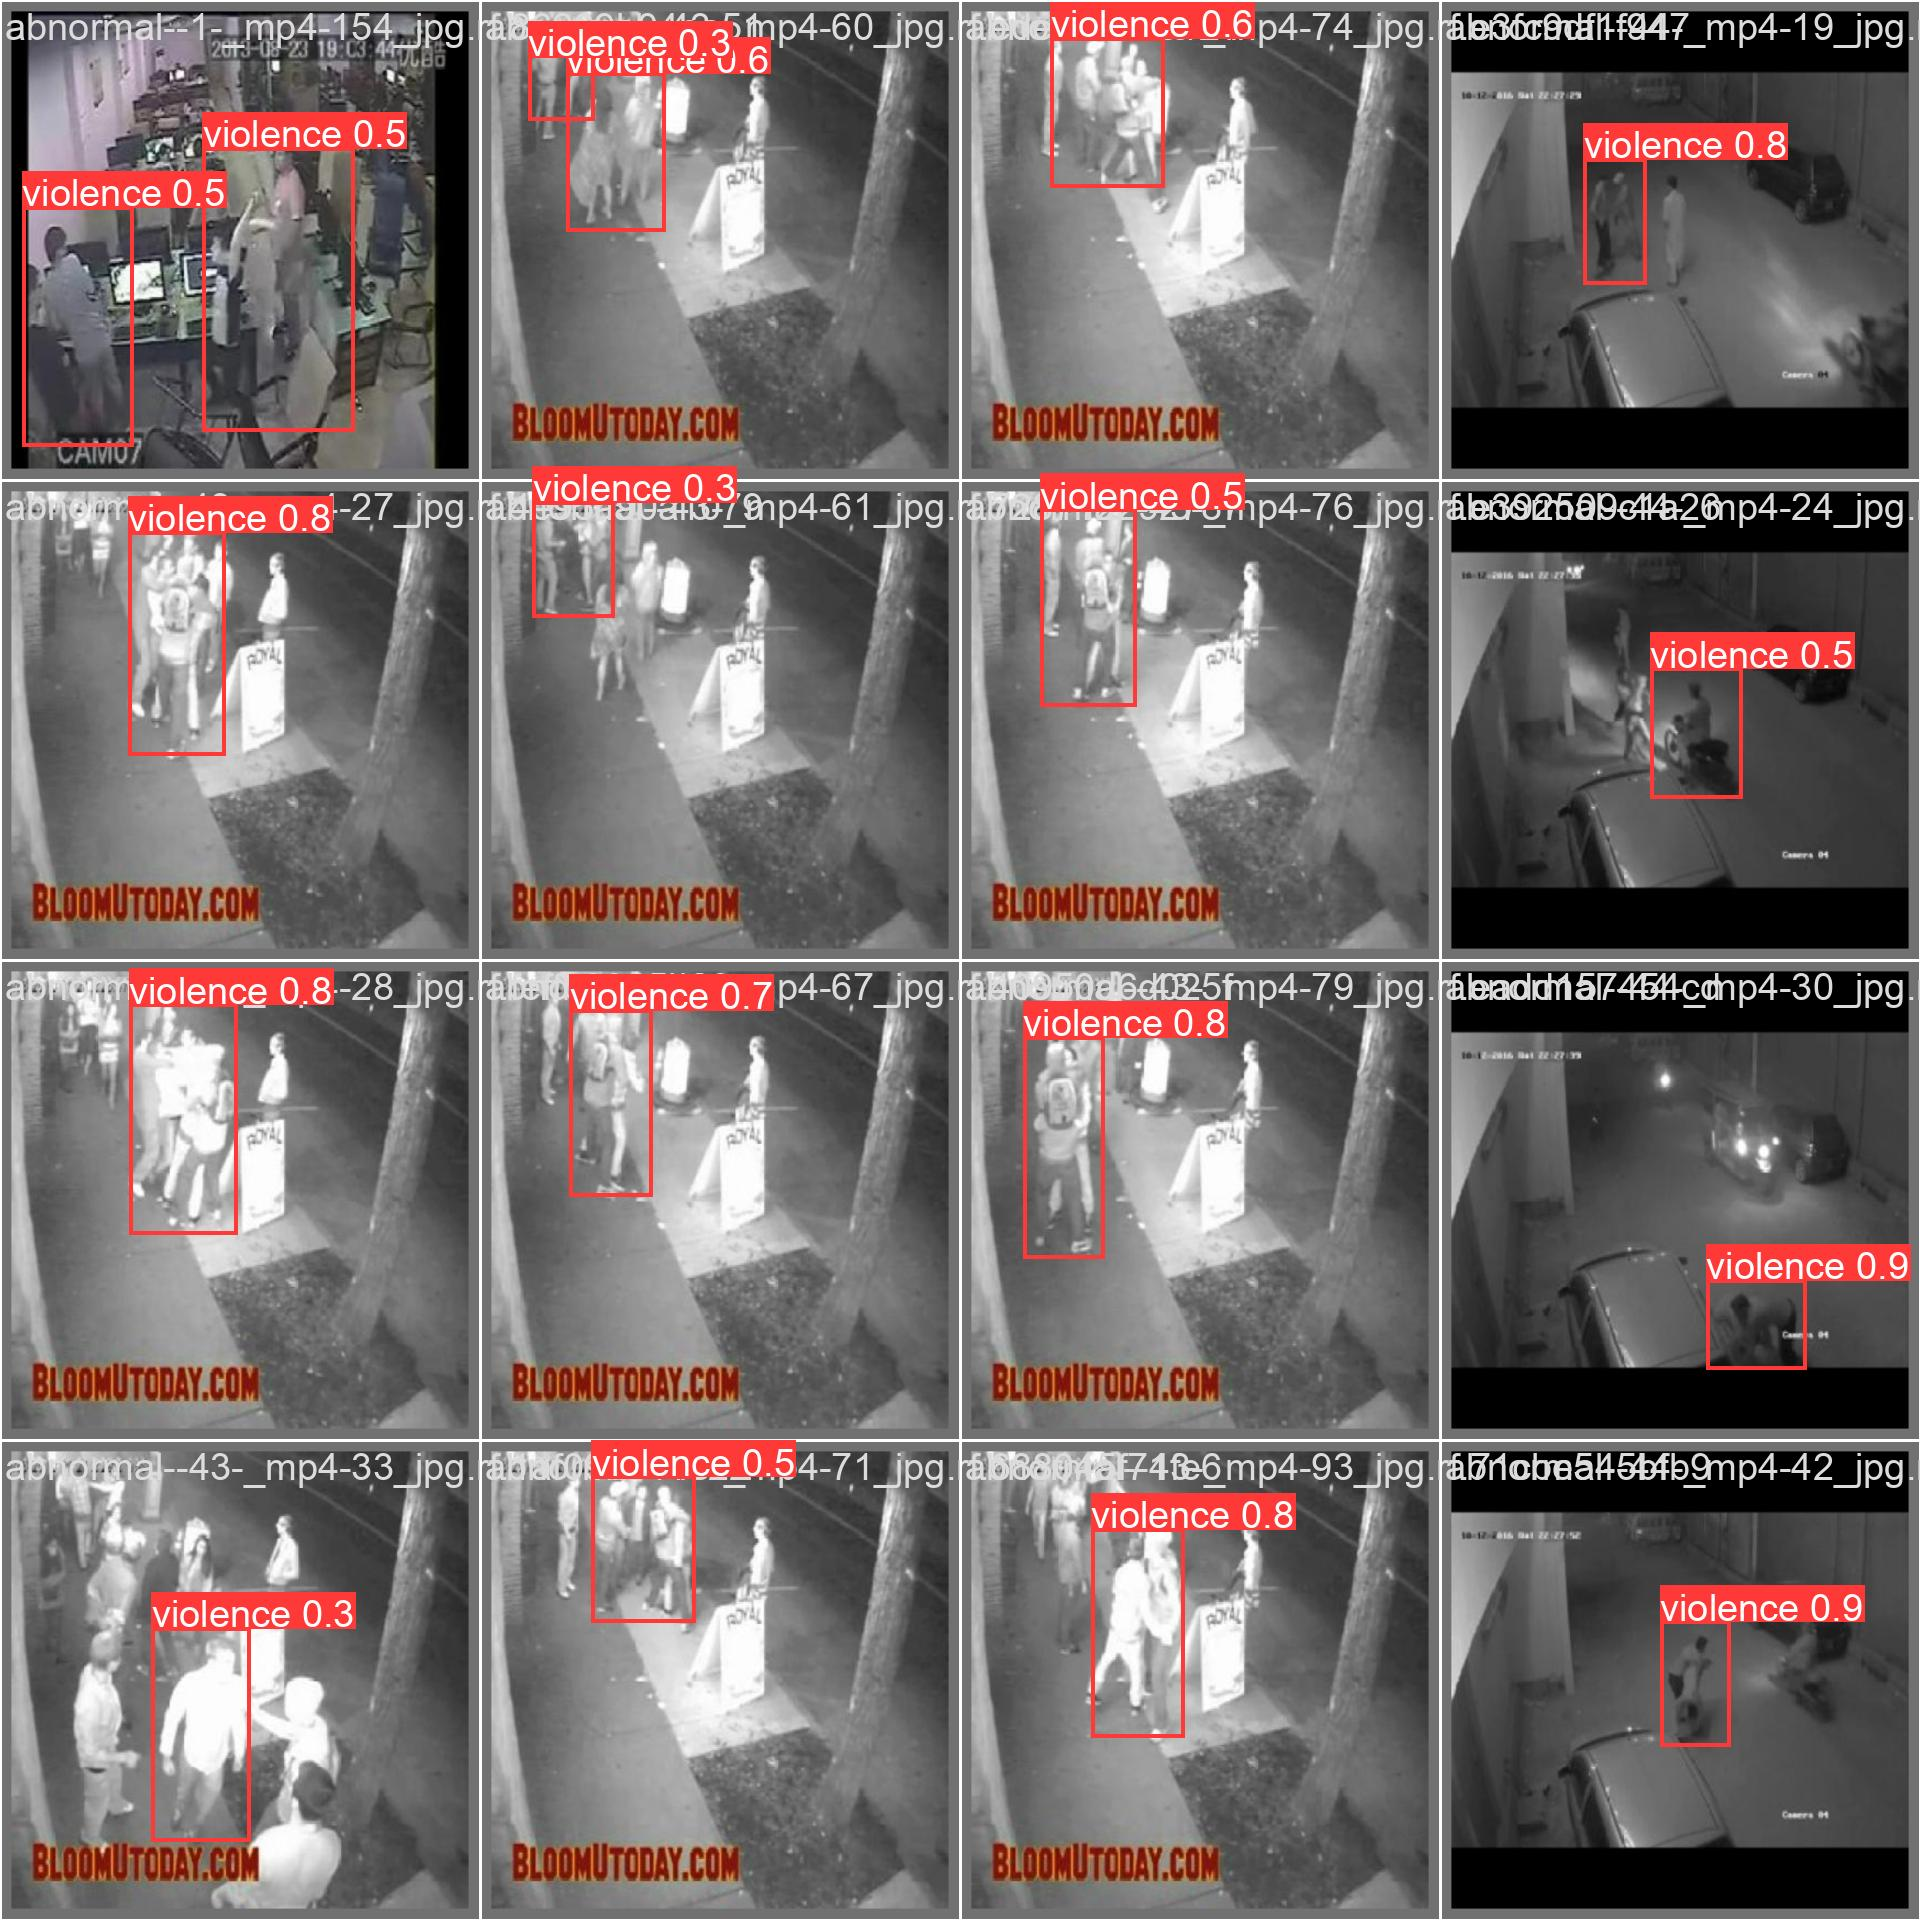

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

#### Model Evaluation on validation set

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data=/content/yolo_datasets/violence-detection-1/data.yaml

/content
Ultralytics YOLOv8.0.134 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients
val: Scanning /content/yolo_datasets/violence-detection-1/valid/labels.cache... 218 images, 0 backgrounds, 0 corrupt: 100% 218/218 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 14/14 [00:05<00:00,  2.60it/s]
                   all        218        263      0.599      0.551       0.57      0.263
Speed: 2.6ms preprocess, 9.4ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val


/content


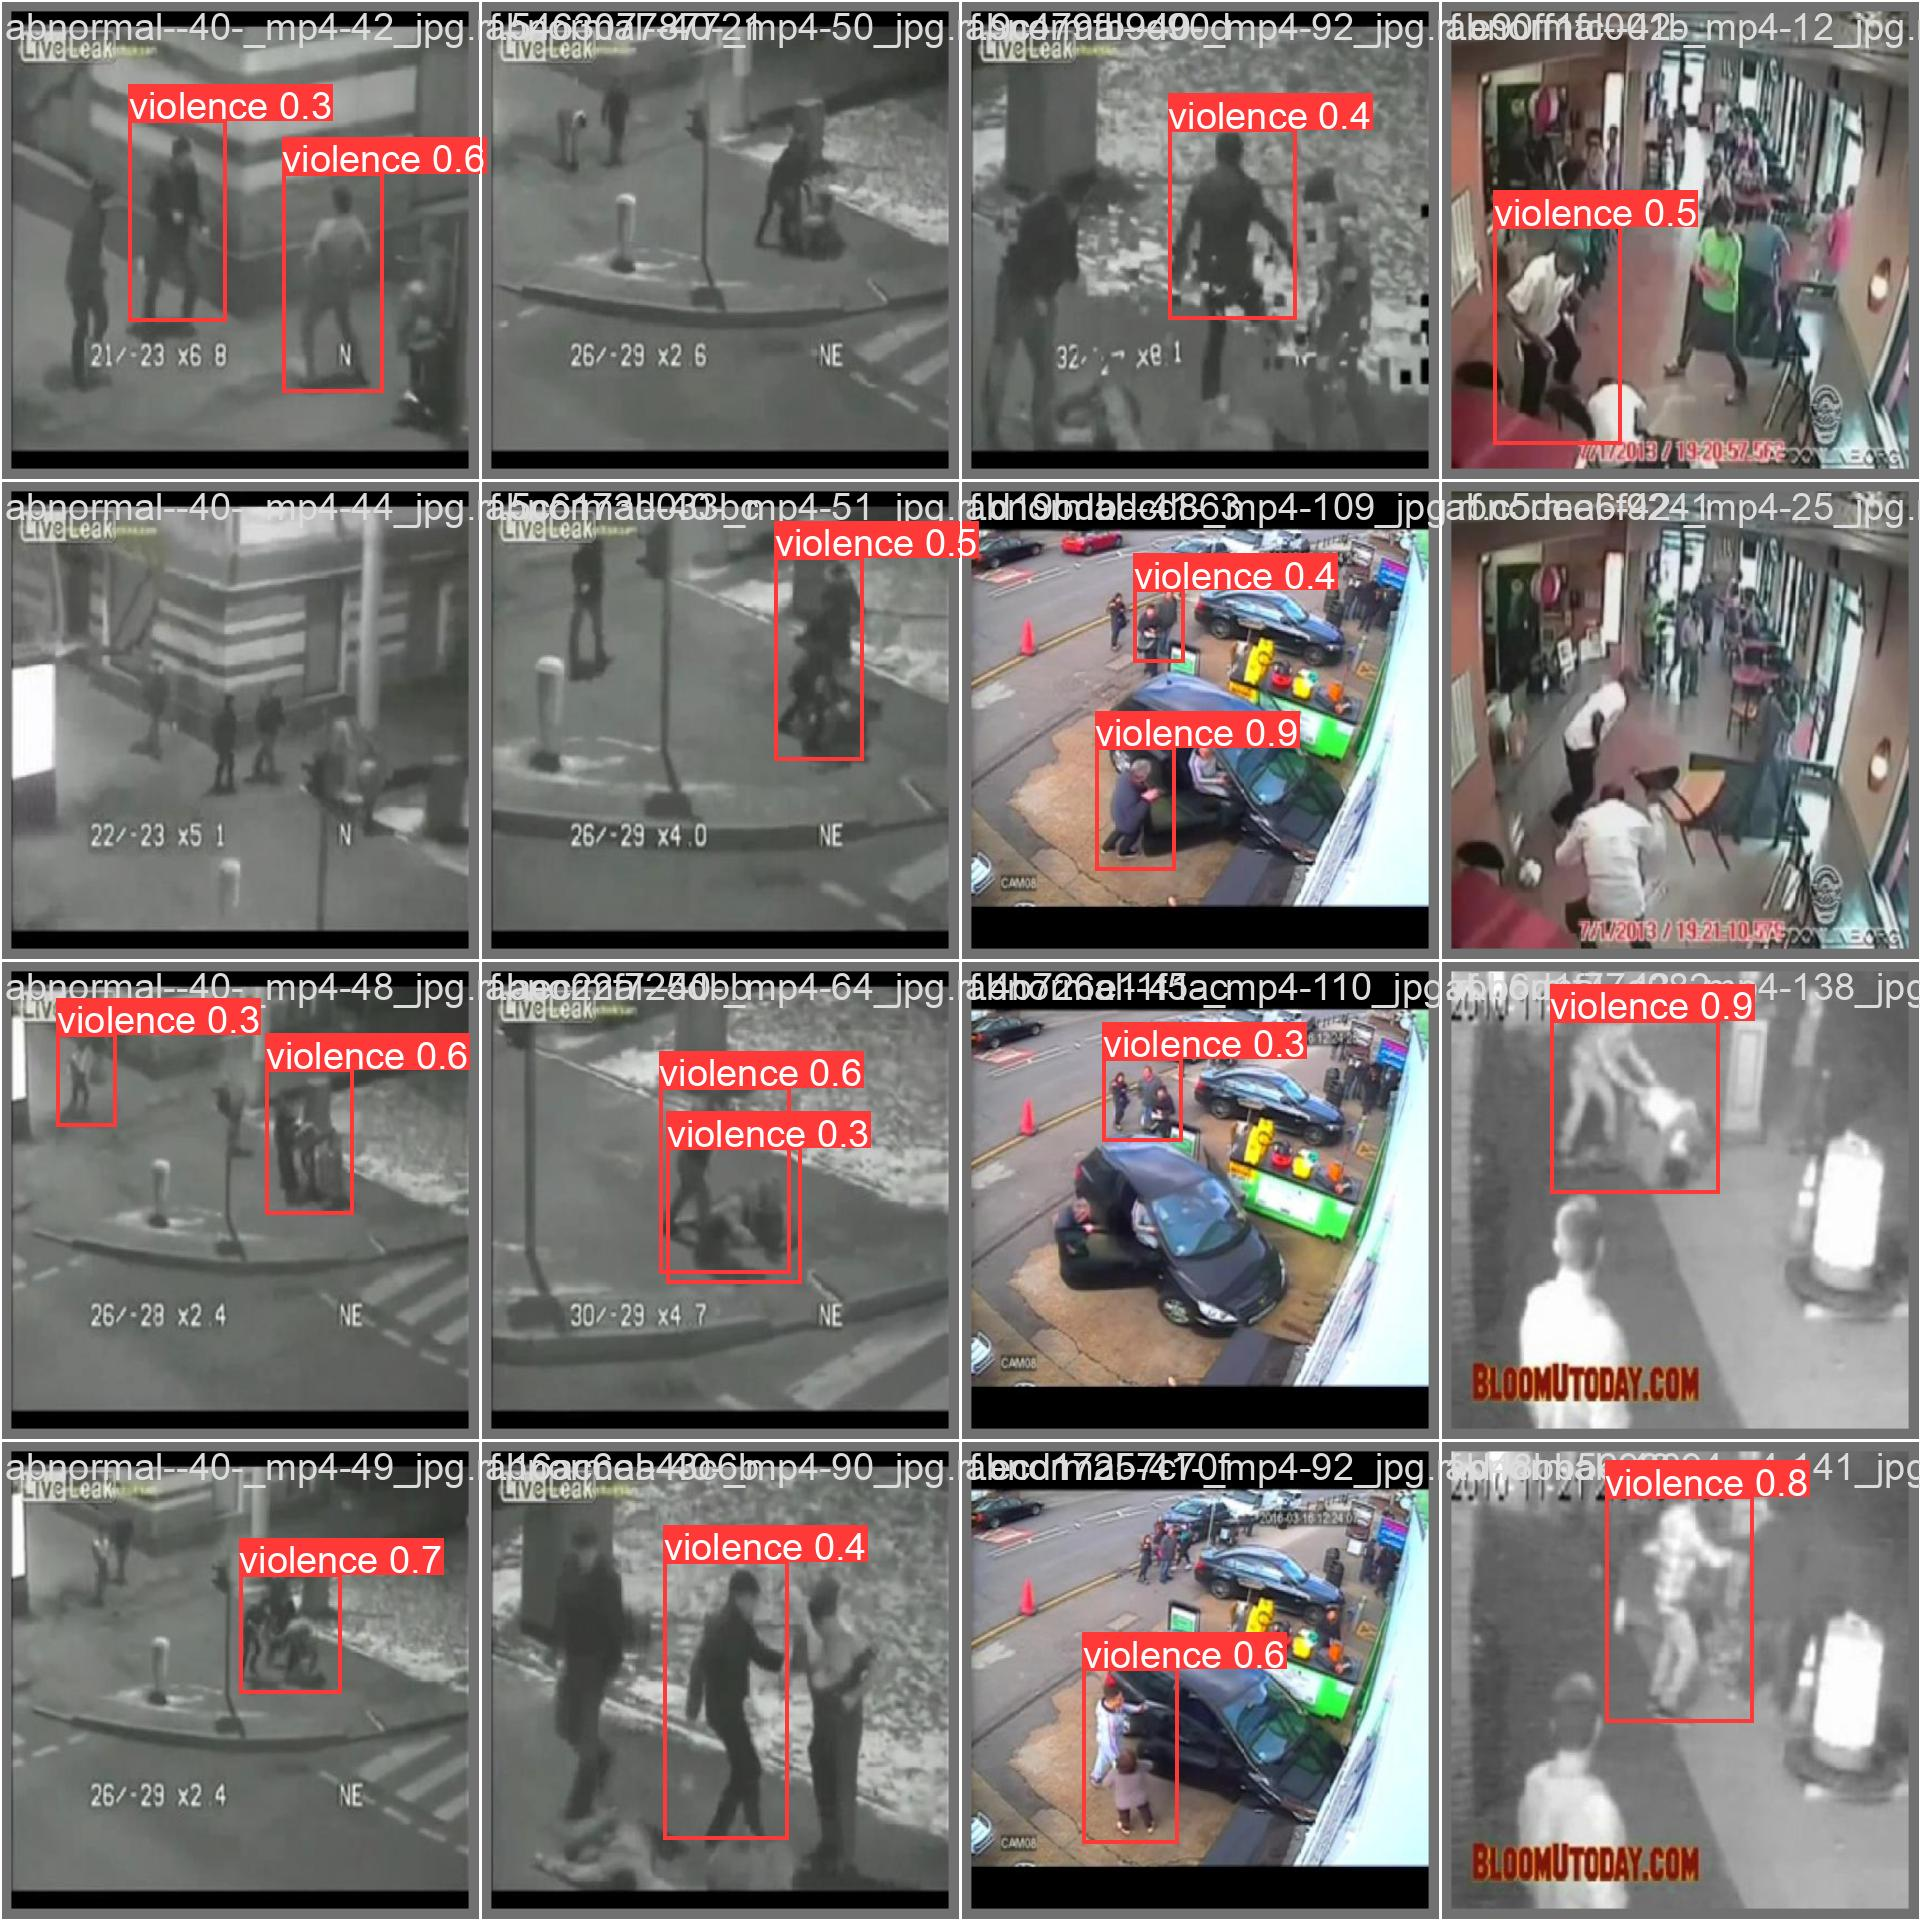

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch1_pred.jpg', width=600)

#### Model Evaluation on test set

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/yolo_datasets/violence-detection-1/test/images save=True

/content
Ultralytics YOLOv8.0.134 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients

image 1/110 /content/yolo_datasets/violence-detection-1/test/images/abnormal--1-_mp4-99_jpg.rf.982d3bfb0d4738e76b0cdf5049d1a71b.jpg: 640x640 1 violence, 15.9ms
image 2/110 /content/yolo_datasets/violence-detection-1/test/images/abnormal--10-_mp4-2_jpg.rf.bdb73330e26169db133ff08e6141a739.jpg: 640x640 1 violence, 16.0ms
image 3/110 /content/yolo_datasets/violence-detection-1/test/images/abnormal--11-_mp4-30_jpg.rf.00f6dafcae7ea131b311a38358431901.jpg: 640x640 1 violence, 15.9ms
image 4/110 /content/yolo_datasets/violence-detection-1/test/images/abnormal--12-_mp4-12_jpg.rf.1cf76947a37cdb86a8f9956d82f0013c.jpg: 640x640 (no detections), 15.9ms
image 5/110 /content/yolo_datasets/violence-detection-1/test/images/abnormal--12-_mp4-9_jpg.rf.63932ac9f4a225a67a2e394fd933fa4b.jpg: 640x640 4 violences, 15.9ms
image 6/110 /content/yolo_

In [ ]:
!ls {HOME}/runs/detect/predict/

abnormal--10-_mp4-2_jpg.rf.bdb73330e26169db133ff08e6141a739.jpg
abnormal--11-_mp4-30_jpg.rf.00f6dafcae7ea131b311a38358431901.jpg
abnormal--12-_mp4-12_jpg.rf.1cf76947a37cdb86a8f9956d82f0013c.jpg
abnormal--12-_mp4-9_jpg.rf.63932ac9f4a225a67a2e394fd933fa4b.jpg
abnormal--13-_mp4-11_jpg.rf.448a4652256fac6c115752a5d7833f37.jpg
abnormal--15-_mp4-53_jpg.rf.22aa858639a5d9ab31d882e52c1c7086.jpg
abnormal--17-_mp4-10_jpg.rf.152a1ba8ceab42865855566cbb3f38a4.jpg
abnormal--17-_mp4-25_jpg.rf.db591a6386b4289490d0f75e05972b44.jpg
abnormal--18-_mp4-21_jpg.rf.25db9b672ca90837b066bda336c0deb2.jpg
abnormal--19-_mp4-4_jpg.rf.54a49234a6fa03f1554f105dbf7c5a26.jpg
abnormal--1-_mp4-99_jpg.rf.982d3bfb0d4738e76b0cdf5049d1a71b.jpg
abnormal--20-_mp4-6_jpg.rf.60674701535de4e9b47172d78577cbe9.jpg
abnormal--20-_mp4-8_jpg.rf.46f13028819a27f6680d9fd65eaa2218.jpg
abnormal--21-_mp4-89_jpg.rf.99eebdd70baf3e2f4a490a6ed9778059.jpg
abnormal--24-_mp4-17_jpg.rf.eabafced20797cd5f11f4a37f62cc4b3.jpg
abnormal--24-_mp4-20_jpg.rf.cb1

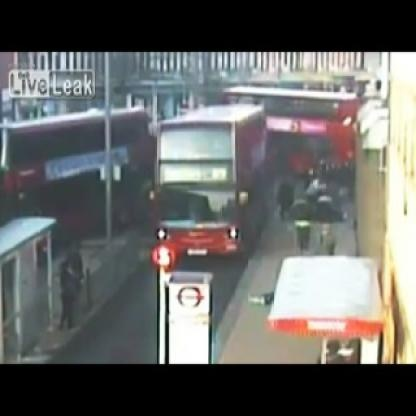

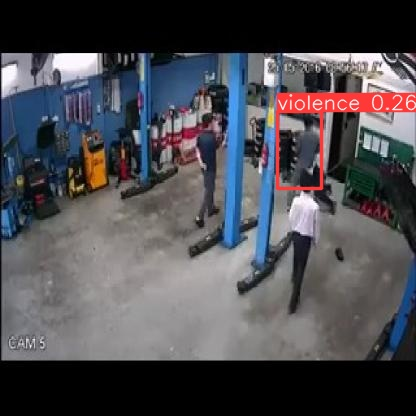

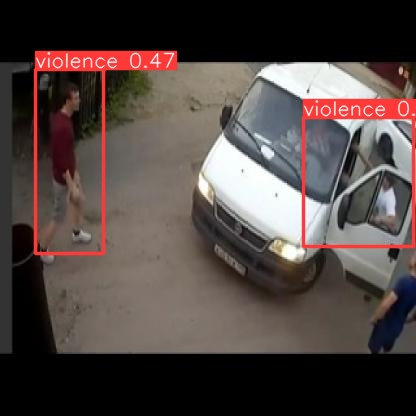

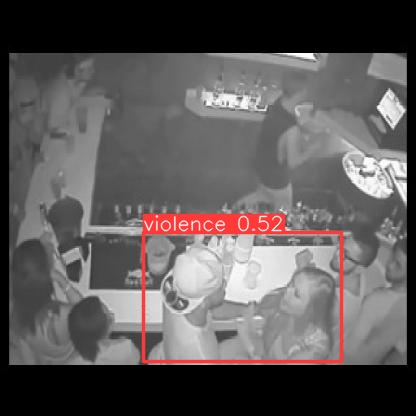

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:4]:
      display(Image(filename=image_path, width=400))
      print("\n")

#### Export Yolov8 model :

In [ ]:
%cd {HOME}

/content


In [ ]:
!yolo export model={HOME}/runs/detect/train/weights/best.pt format=onnx

Ultralytics YOLOv8.0.134 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients

PyTorch: starting from /content/runs/detect/train/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 1.3s, saved as /content/runs/detect/train/weights/best.onnx (42.6 MB)

Export complete (2.4s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640 data=/content/yolo_datasets/violence-detection-1/data.yaml 
Visualize:       https://netron.a